In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import hashlib
import os
import tarfile
from six.moves import urllib
from scipy.stats import reciprocal, expon
from scipy import stats

In [3]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

* Frame the Problem
* Select a Performance Measure
* Check the assumptions

In [4]:
HOUSING_PATH = 'datasets/housing'
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(url=HOUSING_URL, path=HOUSING_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    tgz_path = os.path.join(path, 'housing.tgz')
    urllib.request.urlretrieve(url, tgz_path)
    with tarfile.open(tgz_path) as tar:
        tar.extractall(path=HOUSING_PATH)
        

def load_housing_data(path=HOUSING_PATH):
    csv_path = os.path.join(path, 'housing.csv')
    return pd.read_csv(csv_path)

In [ ]:
fetch_housing_data()

In [ ]:
housing = load_housing_data()

In [ ]:
housing.head()

In [ ]:
housing.info()

In [ ]:
housing.ocean_proximity.value_counts()

In [ ]:
housing.describe()

In [ ]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

#### Create a Test Set

In [ ]:
def split_train_test(data, test_ratio, random_state=0):
    np.random.seed(random_state)
    shuffled_idx = np.random.permutation(len(data))
    n_test = int(len(data) * test_ratio)
    test_idx = shuffled_idx[:n_test]
    train_idx = shuffled_idx[n_test:]
    return data.iloc[train_idx, :], data.iloc[test_idx, :]

In [ ]:
train_set, test_set = split_train_test(housing, test_ratio=.2)

train_set.shape, test_set.shape

In [ ]:
def test_set_check(identifier, test_ratio, hash_func):
    return hash_func(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash_func=hashlib.md5):
    test_idx = data[id_column].map(lambda id_: test_set_check(id_, test_ratio, hash_func))
    return data.loc[~test_idx, :], data.loc[test_idx, :]

In [ ]:
housing = housing.reset_index()

In [ ]:
train_set, test_set = split_train_test_by_id(housing, test_ratio=.2, id_column='index')

In [ ]:
train_set.head()

In [ ]:
train_set.shape, test_set.shape

#### Stratified sampling (by median income category)

In [ ]:
pd.value_counts(np.ceil(housing['median_income'] / 1.5)).sort_index()

In [ ]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

In [ ]:
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [ ]:
housing.income_cat.value_counts()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

In [ ]:
for tr_idx, ts_idx in split.split(housing, housing['income_cat']):
    strat_train_set = housing.iloc[tr_idx].copy()
    strat_test_set = housing.iloc[ts_idx].copy()

In [ ]:
strat_train_set.shape, strat_test_set.shape

In [ ]:
pd.value_counts(strat_test_set['income_cat'], normalize=True)

In [ ]:
pd.value_counts(strat_train_set['income_cat'], normalize=True)

In [ ]:
for df in (strat_test_set, strat_train_set):
    df.drop(['income_cat'], axis=1, inplace=True)

In [ ]:
strat_test_set.columns

#### Discover and Visualize

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing.info()

In [ ]:
housing.plot.scatter(x='longitude', y='latitude', alpha=.1)

In [ ]:
housing.plot.scatter(x='longitude', y='latitude', alpha=.4, 
                     s=housing['population']/100, 
                     c='median_house_value',
                     cmap=plt.cm.jet, figsize=(15, 12), label='population',
                     colorbar=True, )
plt.legend()

In [ ]:
pearson_corr = housing.corr()
spearman_corr = housing.corr(method='spearman')

In [ ]:
pearson_corr['median_house_value'].sort_values(ascending=False)

In [ ]:
spearman_corr['median_house_value'].sort_values(ascending=False)

In [ ]:
col_names = pearson_corr['median_house_value'].sort_values(ascending=False)[:4].index

scatter_matrix(housing[col_names], figsize=(12, 8))
plt.show()

In [ ]:
housing.plot.scatter(x='median_income', y='median_house_value', alpha=.4)

In [ ]:
housing.columns

#### Experimenting with attribute combinations

In [ ]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
corr_mat = housing.corr()

In [ ]:
corr_mat['median_house_value'].sort_values(ascending=False)

#### Prepare the data for machine learning algorithms
* Data Cleaning
* Custom Transformers
* Feature Scaling

In [ ]:
housing.info()

In [ ]:
ohe = OneHotEncoder(sparse=False)
le = LabelEncoder()
lb = LabelBinarizer()

In [ ]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded = le.fit_transform(housing_cat)

In [ ]:
housing_cat_encoded

In [ ]:
le.classes_

In [ ]:
housing_cat_ohe = ohe.fit_transform(housing_cat_encoded[:, None])

In [ ]:
housing_cat_ohe

In [ ]:
housing_cat_ohe.shape

In [ ]:
housing_cat_ohe = lb.fit_transform(housing['ocean_proximity'])

In [ ]:
housing_cat_ohe

In [ ]:
lb.classes_

In [ ]:
housing.drop(['index', 'median_house_value'], axis=1, inplace=True)

In [ ]:
housing_columns = list(housing.columns)
housing_columns

In [ ]:
room_idx = housing_columns.index('total_rooms')
bedroom_idx = housing_columns.index('total_bedrooms')
population_idx = housing_columns.index('population')
households_idx = housing_columns.index('households')

class CombineAttributeAdder(BaseEstimator, TransformerMixin):
    '''
    combined columns:
        - population per household
        - room per household
        - bedroom per total_room
    '''
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        population_per_household = X[:, population_idx] / X[:, households_idx]
        room_per_house = X[:, room_idx] / X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:, bedroom_idx] / X[:, room_idx]
            return np.c_[X, room_per_house, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, room_per_house, population_per_household]
        
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_names):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_names].values
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.n_features = None
        self.label_binarizers = []
    
    def fit(self, X, y=None):
        self.n_features = X.shape[1]
        for feature in X.T:
            le = LabelBinarizer(sparse_output=False)
            le.fit(feature)
            self.label_binarizers.append(le)
        return self
    
    def transform(self, X, y=None):
        assert X.shape[1] == self.n_features
        if self.n_features == 1:
            return self.label_binarizers[0].transform(X)
        else:
            return np.hstack(le.transform(feature) for le, feature in zip(self.label_binarizers, X.T))

In [ ]:
attr_adder = CombineAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs.shape

In [ ]:
housing.shape

In [ ]:
housing.columns

#### Full Pipeline 

In [ ]:
housing['ocean_proximity'] = le.fit_transform(housing['ocean_proximity'])

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing_labels = housing['median_house_value'].values
housing.drop(['index', 'median_house_value'], axis=1, inplace=True)

In [ ]:
cat_columns = ['ocean_proximity']
num_columns = list(housing.drop('ocean_proximity', axis=1).columns)


# num pipeline
num_pipe = Pipeline([
    ('selector', DataFrameSelector(num_columns)),
    ('imputer', Imputer(strategy='median')),
    ('attrib_adder', CombineAttributeAdder(add_bedrooms_per_room=True)),
    ('scaler', StandardScaler())
])

# cat pipeline
cat_pipe = Pipeline([
    ('selector', DataFrameSelector(cat_columns)),
    #('label_encoder', LabelEncoder()),
    #('onehot_encoder', OneHotEncoder(sparse=False)),
    ('onehot_encoder', CustomLabelBinarizer()),
    
])

# combine pipeline

full_pipe = FeatureUnion(transformer_list=[
    ('num_pipe', num_pipe),
    ('cat_pipe', cat_pipe),
])

In [65]:
housing_prepared = full_pipe.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [66]:
housing_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

#### Select and Train Model

In [67]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [68]:
y_pred = lin_reg.predict(housing_prepared)

Text(0,0.5,'predict')

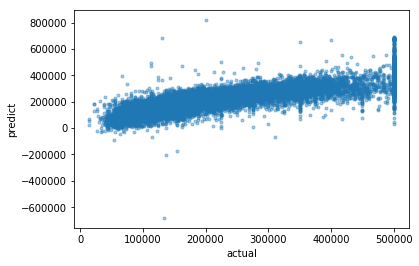

In [69]:
plt.scatter(housing_labels, y_pred, marker='.', alpha=.4)
plt.xlabel('actual')
plt.ylabel('predict')

In [70]:
np.sqrt(mean_squared_error(housing_labels, y_pred))

68628.19819848922

In [71]:
strat_train_set['median_house_value'].describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [72]:
def display(scores):
    print('''scores: {}\nmean: {:.4f}\nstdev: {:.4f}'''.format(scores.round(2), 
                                                               np.mean(scores), 
                                                               np.std(scores)))

In [166]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [184]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         cv=10, scoring='neg_mean_squared_error')

In [185]:
rmse_scores = np.sqrt(-scores)

In [187]:
display(rmse_scores)

scores: [67302.54 67610.78 71849.48 69457.92 72649.61 73630.76 70249.05 69953.15
 75796.7  70016.08]
mean: 70851.6055
stdev: 2516.2628


In [188]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse = np.sqrt(-lin_scores)

In [189]:
display(lin_rmse)

scores: [66782.74 66960.12 70347.95 74739.57 68031.13 71193.84 64969.63 68281.61
 71552.92 67665.1 ]
mean: 69052.4614
stdev: 2731.6740


In [191]:
rf_reg = RandomForestRegressor()
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_labels, 
                            scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-rf_scores)

In [192]:
display(rf_rmse)

scores: [51944.32 50025.68 53606.21 55464.32 52435.12 55824.97 52515.79 50593.46
 55498.27 52787.83]
mean: 53069.5969
stdev: 1922.6214


In [197]:
svr = SVR()
svr_scores = cross_val_score(svr, housing_prepared, housing_labels, 
                            scoring='neg_mean_squared_error', cv=10)
svr_rmse = np.sqrt(-svr_scores)
display(svr_rmse)

scores: [111393.33 119546.71 116961.   120449.02 117622.2  122303.77 117640.1
 121459.64 120348.51 118025.62]
mean: 118574.9902
stdev: 2934.1329


In [195]:
knn = KNeighborsRegressor()
knn_scores = cross_val_score(knn, housing_prepared, housing_labels, 
                            scoring='neg_mean_squared_error', cv=10)
knn_rmse = np.sqrt(-knn_scores)
display(knn_rmse)

scores: [62101.44 61885.87 63465.55 63103.88 60076.54 63938.88 59220.34 61911.86
 63187.08 61093.35]
mean: 61998.4789
stdev: 1442.7092


#### Fine-Tune model

In [77]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [78]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [81]:
np.sqrt(-grid_search.best_score_), grid_search.best_params_

(49658.19384669214, {'max_features': 6, 'n_estimators': 30})

In [82]:
result_df = pd.DataFrame(grid_search.cv_results_)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, ple

In [83]:
result_df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.137949,0.006356,-4.208946e+09,-1.097016e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.911198e+09,...,-4.291377e+09,-1.053189e+09,-4.239213e+09,-1.082697e+09,-4.385881e+09,-1.165328e+09,0.002451,0.000201,1.598435e+08,3.923546e+07
1,0.451074,0.018354,-3.148739e+09,-5.873382e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-2.969983e+09,...,-3.381782e+09,-5.912354e+08,-2.906483e+09,-5.932375e+08,-3.121113e+09,-5.722285e+08,0.008574,0.000314,1.960557e+08,8.306678e+06
2,1.331675,0.052623,-2.798720e+09,-4.336493e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.640777e+09,...,-2.823113e+09,-4.282650e+08,-2.651335e+09,-4.369904e+08,-2.944253e+09,-4.324310e+08,0.013006,0.000358,1.317431e+08,3.180987e+06
3,0.220427,0.006055,-3.624002e+09,-9.607986e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.292653e+09,...,-3.718897e+09,-9.325385e+08,-3.358965e+09,-9.223599e+08,-3.967746e+09,-1.000366e+09,0.004637,0.000372,2.577217e+08,3.217465e+07
4,0.731919,0.018451,-2.787909e+09,-5.193525e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.656179e+09,...,-2.841763e+09,-4.932609e+08,-2.640974e+09,-5.310075e+08,-2.972465e+09,-5.411767e+08,0.010279,0.000371,1.245170e+08,1.863225e+07


In [84]:
result_df['RMSE'] = np.sqrt(-result_df['mean_test_score'])

In [88]:
result_df[['RMSE', 'params']].sort_values(by='RMSE').head(10)

,RMSE,params
8,49658.193847,"{'max_features': 6, 'n_estimators': 30}"
11,50012.151701,"{'max_features': 8, 'n_estimators': 30}"
5,50664.124356,"{'max_features': 4, 'n_estimators': 30}"
17,51666.778242,"{'max_features': 4, 'bootstrap': False, 'n_est..."
10,52228.579422,"{'max_features': 8, 'n_estimators': 10}"
15,52419.717677,"{'max_features': 3, 'bootstrap': False, 'n_est..."
7,52595.666690,"{'max_features': 6, 'n_estimators': 10}"
4,52800.648696,"{'max_features': 4, 'n_estimators': 10}"
2,52902.931945,"{'max_features': 2, 'n_estimators': 30}"
13,54536.918149,"{'max_features': 2, 'bootstrap': False, 'n_est..."


In [89]:
grid_search.best_estimator_.feature_importances_

array([7.88229601e-02, 7.59201265e-02, 4.12175828e-02, 1.82426065e-02,
       1.64433431e-02, 1.71303991e-02, 1.58508972e-02, 3.37819165e-01,
       6.37611916e-02, 1.06958489e-01, 6.61074814e-02, 7.98015809e-03,
       1.46132715e-01, 5.39772933e-05, 3.03990750e-03, 4.51900064e-03])

In [90]:
full_pipe

FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(column_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', s...DataFrameSelector(column_names=['ocean_proximity'])), ('onehot_encoder', CustomLabelBinarizer())]))],
       transformer_weights=None)

In [91]:
num_pipe

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(column_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attrib_adder', CombineAttributeAdder(add_bedrooms_per_room=True)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [102]:
cat_ohe_attribs = list(cat_pipe.steps[1][1].label_binarizers[0].classes_)

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

attributes = num_columns + extra_attribs + cat_ohe_attribs

In [137]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [106]:
pd.Series(data=grid_search.best_estimator_.feature_importances_, 
          index=attributes).sort_values(ascending=False)

median_income         0.337819
INLAND                0.146133
pop_per_hhold         0.106958
longitude             0.078823
latitude              0.075920
bedrooms_per_room     0.066107
rooms_per_hhold       0.063761
housing_median_age    0.041218
total_rooms           0.018243
population            0.017130
total_bedrooms        0.016443
households            0.015851
<1H OCEAN             0.007980
NEAR OCEAN            0.004519
NEAR BAY              0.003040
ISLAND                0.000054
dtype: float64

In [107]:
final_model = grid_search.best_estimator_

In [109]:
X_test = strat_test_set.drop(['index', 'median_house_value'], axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [110]:
X_test_prepared = full_pipe.transform(X_test)

In [111]:
X_test_prepared.shape, y_test.shape

((4128, 16), (4128,))

In [112]:
final_preds = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_preds)

In [113]:
np.sqrt(final_mse)

47666.87632899844

In [127]:
sqr_errors = (final_preds - y_test)**2

In [133]:
ci = .95
mean = np.mean(sqr_errors)
tscore = stats.t.ppf((1+ci)/2, len(sqr_errors)-1)
margin_error = tscore * np.std(sqr_errors, ddof=1) / np.sqrt(len(sqr_errors))

np.sqrt(mean - margin_error), np.sqrt(mean + margin_error)

(45672.68259711371, 49580.92639625983)

In [135]:
np.sqrt(stats.t.interval(ci, len(sqr_errors)-1, loc=mean, scale=stats.sem(sqr_errors)))

array([45672.68259711, 49580.92639626])

In [116]:
svr_params = [
    {'kernel': ['linear', 'rbf'], 'C': [.01, .1, 1, 10, 100]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [.01, .1, 1, 10, 100]}
             ]

svr_grid = GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [117]:
svr_grid.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 38.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10, 100]}, {'degree': [2, 3], 'kernel': ['poly'], 'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [118]:
svr_grid.best_params_

{'C': 100, 'kernel': 'linear'}

In [119]:
np.sqrt(-svr_grid.best_score_)

71603.12196479437

In [125]:
random_params = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1)
}

random_grid = RandomizedSearchCV(SVR(), random_params, cv=5, n_iter=50, n_jobs=4, 
                                 scoring='neg_mean_squared_error', verbose=2)

random_grid.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [138]:
def get_top_k_indices(k, values):
    return np.argsort(values)[-k:]

class FeatureImportanceSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, k, feature_importances):
        self.k = k
        self.feature_importances = feature_importances
        self.cols = get_top_k_indices(self.k, self.feature_importances)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[:, self.cols]

In [140]:
preparation_and_feature_selection_pipe = Pipeline([
    ('full_pipe', full_pipe),
    ('select_k', FeatureImportanceSelector(5, feature_importances)),
])

In [148]:
a = preparation_and_feature_selection_pipe.fit_transform(housing)
a.shape

(16512, 5)

In [151]:
top_k = preparation_and_feature_selection_pipe.steps[1][1].cols
top_k

array([ 1,  0,  9, 12,  7], dtype=int64)

In [153]:
np.array(attributes)[top_k]

array(['latitude', 'longitude', 'pop_per_hhold', 'INLAND',
       'median_income'], dtype='<U18')

In [149]:
a[:4]

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ],
       [ 0.31357576, -0.01706767,  0.08973561,  1.        , -1.04556555]])

In [152]:
housing_prepared[:4, top_k]

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ],
       [ 0.31357576, -0.01706767,  0.08973561,  1.        , -1.04556555]])

In [176]:
prepare_select_predict_pipe = Pipeline([
    ('prepare', full_pipe),
    ('select', FeatureImportanceSelector(5, feature_importances)),
    ('svr', SVR())
])

params = {
    'svr__C': reciprocal(20, 200000),
    'svr__gamma': expon(scale=1),
    'svr__kernel': ['linear', 'rbf'],
    #'select__k': range(3, 16),
}

rand_grid = RandomizedSearchCV(prepare_select_predict_pipe, params, n_iter=60,
                               cv=5, scoring='neg_mean_squared_error', verbose=2, 
                               n_jobs=1)

In [177]:
rand_grid.fit(housing, housing_labels)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443 
[CV]  svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443, total=   4.2s
[CV] svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443, total=   4.3s
[CV] svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443 
[CV]  svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443, total=   4.1s
[CV] svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443 
[CV]  svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443, total=   4.1s
[CV] svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443 
[CV]  svr__gamma=0.13317109534674468, svr__kernel=linear, svr__C=29.183451220389443, total=   4.2s
[CV] svr__gamma=2.3752145948900507, svr__kernel=rbf, svr__C=44483.14013447289 
[CV]  svr__gamma=2.3752145948900507, svr__kernel=rbf, svr__C=44483.14013447289, total=   7.0s
[CV] svr__gamma=2.3752145948900507, svr__kernel=rbf, svr__C=44483.14013447289 
[CV]  svr__gamma=2.3752145948900507, svr__kernel=rbf, svr__C=44483.14013447289, total=   7.1s
[CV] s

[CV]  svr__gamma=0.8293029727507434, svr__kernel=rbf, svr__C=360.6067332909613, total=   6.6s
[CV] svr__gamma=0.8293029727507434, svr__kernel=rbf, svr__C=360.6067332909613 
[CV]  svr__gamma=0.8293029727507434, svr__kernel=rbf, svr__C=360.6067332909613, total=   6.6s
[CV] svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517 
[CV]  svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517, total=   6.8s
[CV] svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517 
[CV]  svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517, total=   6.8s
[CV] svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517 
[CV]  svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517, total=   7.0s
[CV] svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517 
[CV]  svr__gamma=0.06373002138417821, svr__kernel=rbf, svr__C=670.2568118685517, total=   6.8s
[CV] svr__gamma=0.063730021384178

[CV]  svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249, total=   6.6s
[CV] svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249 
[CV]  svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249, total=   6.4s
[CV] svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249 
[CV]  svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249, total=   6.4s
[CV] svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249 
[CV]  svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249, total=   6.4s
[CV] svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249 
[CV]  svr__gamma=4.583997040188518, svr__kernel=linear, svr__C=47612.43187028249, total=   6.3s
[CV] svr__gamma=0.8901205151406341, svr__kernel=rbf, svr__C=5492.195935574784 
[CV]  svr__gamma=0.8901205151406341, svr__kernel=rbf, svr__C=5492.195935574784, total=   6.4s
[CV] svr__gamma=0.89012

[CV]  svr__gamma=2.0138145947310893, svr__kernel=linear, svr__C=504.62960236237416, total=   4.1s
[CV] svr__gamma=2.0138145947310893, svr__kernel=linear, svr__C=504.62960236237416 
[CV]  svr__gamma=2.0138145947310893, svr__kernel=linear, svr__C=504.62960236237416, total=   4.2s
[CV] svr__gamma=2.0138145947310893, svr__kernel=linear, svr__C=504.62960236237416 
[CV]  svr__gamma=2.0138145947310893, svr__kernel=linear, svr__C=504.62960236237416, total=   4.0s
[CV] svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468 
[CV]  svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468, total=   9.0s
[CV] svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468 
[CV]  svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468, total=   9.1s
[CV] svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468 
[CV]  svr__gamma=4.288269105212363, svr__kernel=rbf, svr__C=77175.71468030468, total=   9.1s
[CV] svr__gamma=4.288269105

[CV]  svr__gamma=0.8907130943453186, svr__kernel=linear, svr__C=174908.5027645921, total=  10.9s
[CV] svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766 
[CV]  svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766, total=   6.7s
[CV] svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766 
[CV]  svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766, total=   6.9s
[CV] svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766 
[CV]  svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766, total=   6.6s
[CV] svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766 
[CV]  svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766, total=   7.1s
[CV] svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766 
[CV]  svr__gamma=4.903124336417172, svr__kernel=linear, svr__C=56504.27811493766, total=   6.8s
[CV] svr__gamma=1.

[CV]  svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182, total=   8.0s
[CV] svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182 
[CV]  svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182, total=   8.0s
[CV] svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182 
[CV]  svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182, total=   7.6s
[CV] svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182 
[CV]  svr__gamma=0.19244802492060917, svr__kernel=linear, svr__C=87861.83672792182, total=   8.2s
[CV] svr__gamma=1.079706511009551, svr__kernel=linear, svr__C=54.74786576328267 
[CV]  svr__gamma=1.079706511009551, svr__kernel=linear, svr__C=54.74786576328267, total=   4.0s
[CV] svr__gamma=1.079706511009551, svr__kernel=linear, svr__C=54.74786576328267 
[CV]  svr__gamma=1.079706511009551, svr__kernel=linear, svr__C=54.74786576328267, total=   4.1s
[CV] 

[CV]  svr__gamma=3.898990582979487, svr__kernel=rbf, svr__C=10974.283458687525, total=   6.9s
[CV] svr__gamma=3.898990582979487, svr__kernel=rbf, svr__C=10974.283458687525 
[CV]  svr__gamma=3.898990582979487, svr__kernel=rbf, svr__C=10974.283458687525, total=   6.8s
[CV] svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123 
[CV]  svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123, total=   6.7s
[CV] svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123 
[CV]  svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123, total=   6.7s
[CV] svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123 
[CV]  svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123, total=   6.6s
[CV] svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123 
[CV]  svr__gamma=2.1717484182350115, svr__kernel=rbf, svr__C=504.5626949008123, total=   6.7s
[CV] svr__gamma=2.1717484182350115, svr__

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 41.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('prepare', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(column_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', I... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D2CDF8DA20>, 'svr__kernel': ['linear', 'rbf'], 'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D2CDF8DEF0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [178]:
np.sqrt(-rand_grid.best_score_)

56062.63312685442

In [179]:
rand_grid.best_params_

{'svr__C': 77175.71468030468,
 'svr__gamma': 4.288269105212363,
 'svr__kernel': 'rbf'}